# CNN + MaxPool
Same as CNN_264 which achieved about 60% accuracy on all cell lines except H1.hESC. 

Here, increase K from 4 to 2 with embed dimen 3.

In [13]:
from datetime import datetime
print(datetime.now())

2023-03-26 20:16:59.855291


In [14]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [15]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=2
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=8 # 20 
EMBED_DIMEN = 2 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
NUM_CELL_LINES=15
EXCLUSIONS = [1]   # exclude H1.hESC
print('Exclusions:',EXCLUSIONS)

Python 3.9.16
sklearn 1.2.2
Exclusions: [1]


In [16]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [17]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [18]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [19]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop1_layer = Dropout(0.5)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop2_layer = Dropout(0.5)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool1_layer)
    cnn.add(drop1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool2_layer)
    cnn.add(drop2_layer)
    cnn.add(flat_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [20]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-26 20:17:01.186521
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 4999, 2)           34        
                                                                 
 conv1d_22 (Conv1D)          (None, 4992, 64)          1088      
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 1247, 64)         0         
 g1D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 1247, 64)          0         
                                                                 
 conv1d_23 (Conv1D)          (None, 1240, 64)          32832     
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 309, 64)          0         
 g1D)                     

## Training

In [21]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [22]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-26 20:17:01.391214
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-26 20:17:08.386078

Training # 1 1
2023-03-26 20:17:08.387854
2023-03-26 20:17:08.388239
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-26 20:17:10.560039


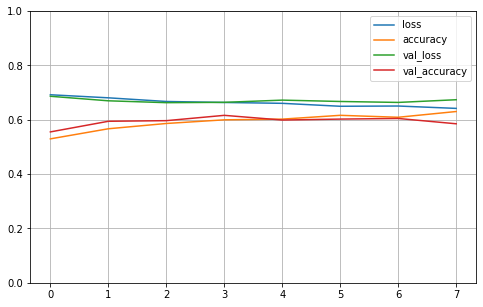


2023-03-26 20:17:32.386454

Testing # 1 1
2023-03-26 20:17:32.386554
2023-03-26 20:17:32.386594
PREDICT
2023-03-26 20:17:32.608313
Test 1:0 458:412 52.64%
Predict 1:0 431:439 49.54%
Test sizes (870, 4999) (870,)
Range of scores: 0.16442415 to 0.8370045
Score threshold 0.5
Confusion matrix
 [[245 167]
 [194 264]]
Normalized matrix
 [[0.2816092  0.19195402]
 [0.22298851 0.30344828]]


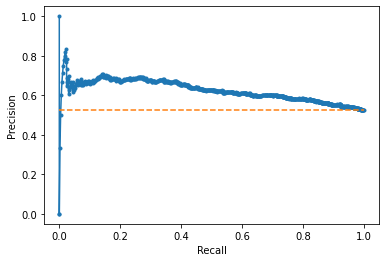

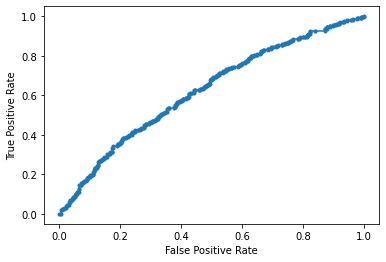

Accuracy: 58.51% Precision: 61.25% Recall: 57.64%
F1: 59.39% MCC: 0.1708
AUPRC: 62.48% AUROC: 62.35%
 accuracy [58.50574712643678]
 precision [61.25290023201856]
 recall [57.64192139737992]
 F1 [59.392575928008995]
 MCC [0.17084732800082914]
 AUPRC [62.48288063853526]
 AUROC [62.34578369440793]
2023-03-26 20:17:33.451146

Training # 1 2
2023-03-26 20:17:33.453044
2023-03-26 20:17:33.453436
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-26 20:17:35.677535


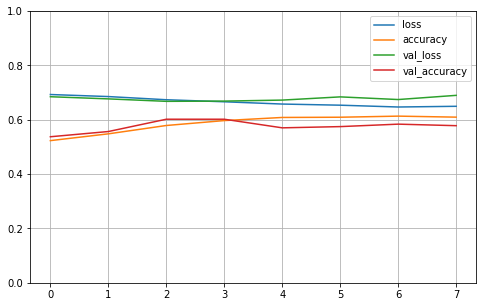


2023-03-26 20:17:49.926264

Testing # 1 2
2023-03-26 20:17:49.926654
2023-03-26 20:17:49.926687
PREDICT
2023-03-26 20:17:50.161397
Test 1:0 442:442 50.00%
Predict 1:0 579:305 65.50%
Test sizes (884, 4999) (884,)
Range of scores: 0.16749676 to 0.89328367
Score threshold 0.5
Confusion matrix
 [[187 255]
 [118 324]]
Normalized matrix
 [[0.21153846 0.28846154]
 [0.13348416 0.36651584]]


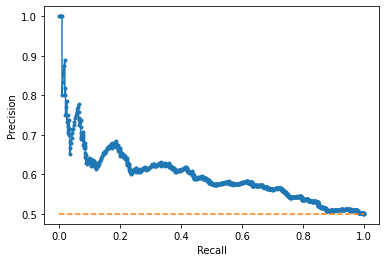

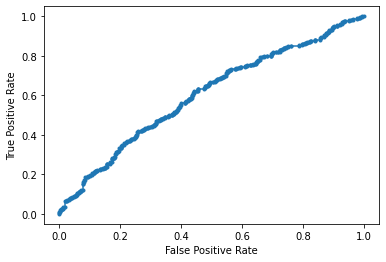

Accuracy: 57.81% Precision: 55.96% Recall: 73.30%
F1: 63.47% MCC: 0.1642
AUPRC: 59.69% AUROC: 60.31%
 accuracy [57.80542986425339]
 precision [55.95854922279793]
 recall [73.30316742081448]
 F1 [63.46718903036239]
 MCC [0.1641949853216919]
 AUPRC [59.68919177144285]
 AUROC [60.309473598001674]
2023-03-26 20:17:50.833184

Training # 1 3
2023-03-26 20:17:50.833325
2023-03-26 20:17:50.833371
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-26 20:17:52.027668


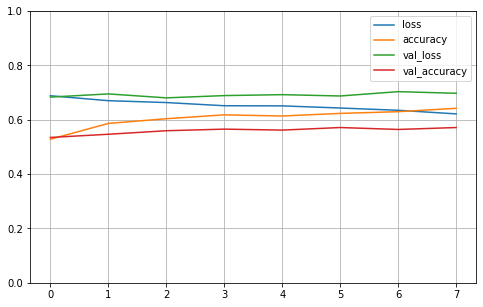


2023-03-26 20:18:13.771129

Testing # 1 3
2023-03-26 20:18:13.772535
2023-03-26 20:18:13.772908
PREDICT
2023-03-26 20:18:14.176547
Test 1:0 442:407 52.06%
Predict 1:0 478:371 56.30%
Test sizes (849, 4999) (849,)
Range of scores: 0.06740429 to 0.92590195
Score threshold 0.5
Confusion matrix
 [[207 200]
 [164 278]]
Normalized matrix
 [[0.24381625 0.23557126]
 [0.19316843 0.32744405]]


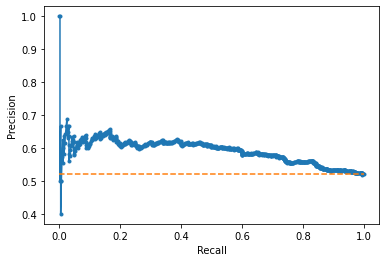

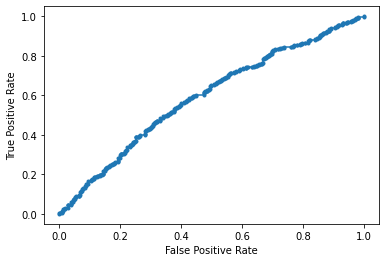

Accuracy: 57.13% Precision: 58.16% Recall: 62.90%
F1: 60.43% MCC: 0.1385
AUPRC: 59.14% AUROC: 59.29%
 accuracy [57.126030624263834]
 precision [58.15899581589959]
 recall [62.89592760180995]
 F1 [60.43478260869565]
 MCC [0.1385465660998522]
 AUPRC [59.13830629185261]
 AUROC [59.291582820994584]
2023-03-26 20:18:15.811554

Training # 1 4
2023-03-26 20:18:15.811728
2023-03-26 20:18:15.811774
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-26 20:18:16.985197


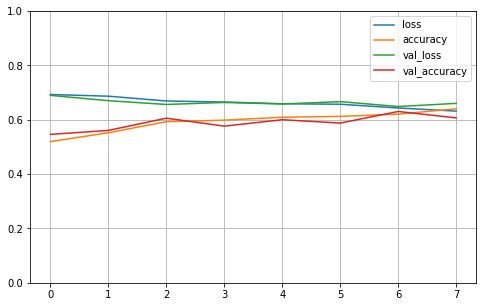


2023-03-26 20:18:31.263635

Testing # 1 4
2023-03-26 20:18:31.263734
2023-03-26 20:18:31.263768
PREDICT
2023-03-26 20:18:31.485522
Test 1:0 459:431 51.57%
Predict 1:0 599:291 67.30%
Test sizes (890, 4999) (890,)
Range of scores: 0.08674873 to 0.9301615
Score threshold 0.5
Confusion matrix
 [[186 245]
 [105 354]]
Normalized matrix
 [[0.20898876 0.2752809 ]
 [0.11797753 0.39775281]]


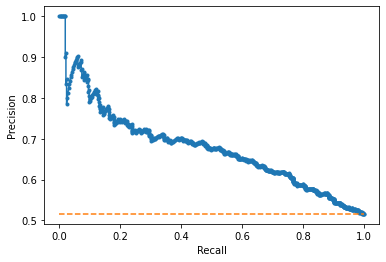

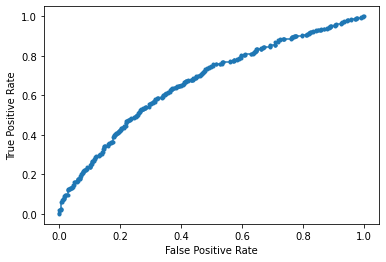

Accuracy: 60.67% Precision: 59.10% Recall: 77.12%
F1: 66.92% MCC: 0.2160
AUPRC: 67.84% AUROC: 66.73%
 accuracy [60.67415730337079]
 precision [59.09849749582637]
 recall [77.12418300653596]
 F1 [66.91871455576559]
 MCC [0.2160454954950881]
 AUPRC [67.83668968670287]
 AUROC [66.73288547179635]
2023-03-26 20:18:32.207970

Training # 1 5
2023-03-26 20:18:32.208122
2023-03-26 20:18:32.208165
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-26 20:18:33.391503


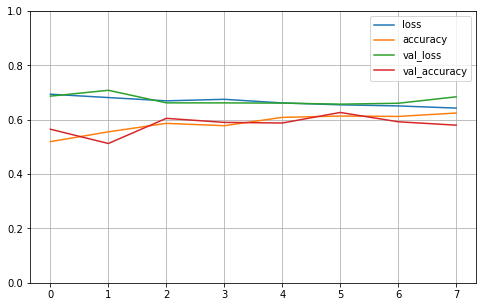


2023-03-26 20:18:47.980520

Testing # 1 5
2023-03-26 20:18:47.980647
2023-03-26 20:18:47.980687
PREDICT
2023-03-26 20:18:48.207633
Test 1:0 457:419 52.17%
Predict 1:0 731:145 83.45%
Test sizes (876, 4999) (876,)
Range of scores: 0.09367386 to 0.9099774
Score threshold 0.5
Confusion matrix
 [[ 98 321]
 [ 47 410]]
Normalized matrix
 [[0.11187215 0.36643836]
 [0.05365297 0.46803653]]


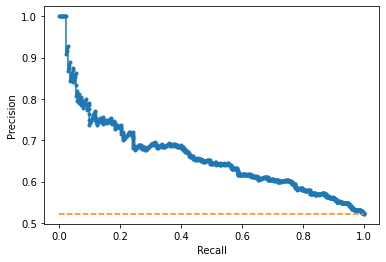

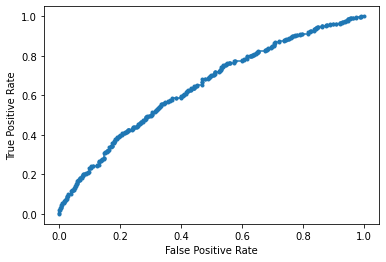

Accuracy: 57.99% Precision: 56.09% Recall: 89.72%
F1: 69.02% MCC: 0.1761
AUPRC: 66.09% AUROC: 64.56%
 accuracy [57.99086757990868]
 precision [56.0875512995896]
 recall [89.71553610503283]
 F1 [69.02356902356902]
 MCC [0.17613464381793173]
 AUPRC [66.08851256777764]
 AUROC [64.56238935049065]
2023-03-26 20:18:48.887834

Training # 2 1
2023-03-26 20:18:48.891453
2023-03-26 20:18:48.891503
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-26 20:18:50.064546


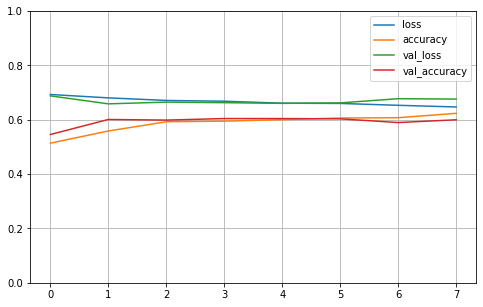


2023-03-26 20:19:04.468467

Testing # 2 1
2023-03-26 20:19:04.468848
2023-03-26 20:19:04.468889
PREDICT
2023-03-26 20:19:04.704162
Test 1:0 472:415 53.21%
Predict 1:0 639:248 72.04%
Test sizes (887, 4999) (887,)
Range of scores: 0.0711627 to 0.9528658
Score threshold 0.5
Confusion matrix
 [[154 261]
 [ 94 378]]
Normalized matrix
 [[0.17361894 0.29425028]
 [0.1059752  0.42615558]]


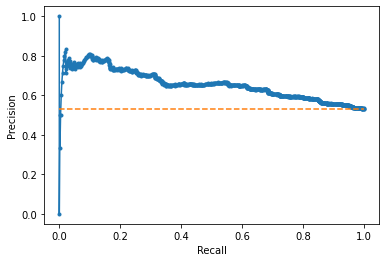

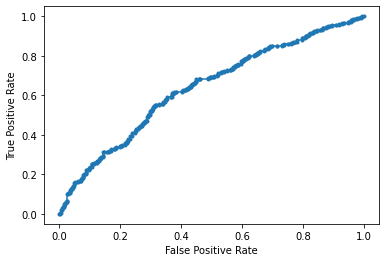

Accuracy: 59.98% Precision: 59.15% Recall: 80.08%
F1: 68.05% MCC: 0.1912
AUPRC: 65.47% AUROC: 63.87%
 accuracy [59.97745208568207]
 precision [59.154929577464785]
 recall [80.08474576271186]
 F1 [68.04680468046804]
 MCC [0.19115029625034574]
 AUPRC [65.46652350370368]
 AUROC [63.87175821931794]
2023-03-26 20:19:05.527969

Training # 2 2
2023-03-26 20:19:05.529850
2023-03-26 20:19:05.530256
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-26 20:19:07.701163


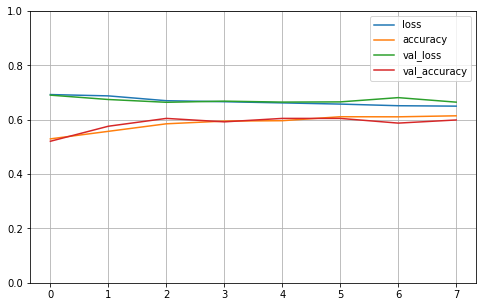


2023-03-26 20:19:29.730847

Testing # 2 2
2023-03-26 20:19:29.730990
2023-03-26 20:19:29.731030
PREDICT
2023-03-26 20:19:29.981670
Test 1:0 452:416 52.07%
Predict 1:0 500:368 57.60%
Test sizes (868, 4999) (868,)
Range of scores: 0.16712716 to 0.84644854
Score threshold 0.5
Confusion matrix
 [[218 198]
 [150 302]]
Normalized matrix
 [[0.25115207 0.2281106 ]
 [0.17281106 0.34792627]]


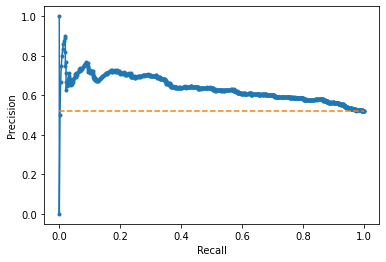

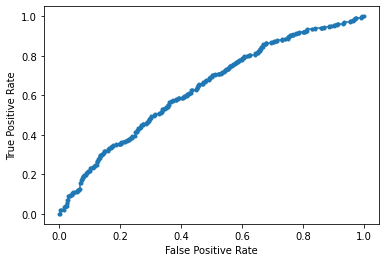

Accuracy: 59.91% Precision: 60.40% Recall: 66.81%
F1: 63.45% MCC: 0.1943
AUPRC: 63.68% AUROC: 63.78%
 accuracy [59.907834101382484]
 precision [60.4]
 recall [66.8141592920354]
 F1 [63.4453781512605]
 MCC [0.19427426892103603]
 AUPRC [63.681267086538625]
 AUROC [63.78276038121171]
2023-03-26 20:19:30.670062

Training # 2 3
2023-03-26 20:19:30.670193
2023-03-26 20:19:30.670237
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-26 20:19:31.894152


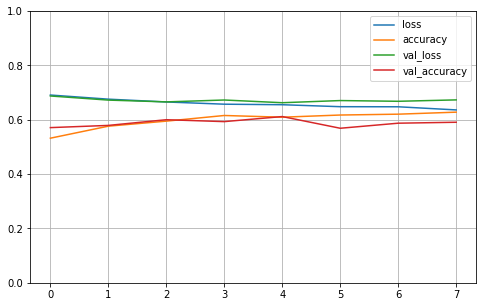


2023-03-26 20:19:46.555524

Testing # 2 3
2023-03-26 20:19:46.557316
2023-03-26 20:19:46.557717
PREDICT
2023-03-26 20:19:46.969500
Test 1:0 453:407 52.67%
Predict 1:0 563:297 65.47%
Test sizes (860, 4999) (860,)
Range of scores: 0.05389913 to 0.8990197
Score threshold 0.5
Confusion matrix
 [[176 231]
 [121 332]]
Normalized matrix
 [[0.20465116 0.26860465]
 [0.14069767 0.38604651]]


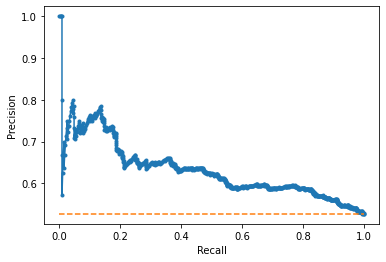

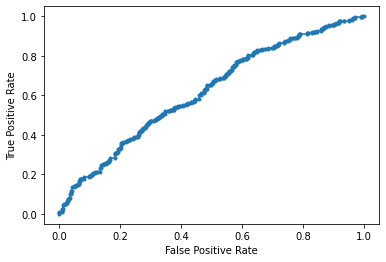

Accuracy: 59.07% Precision: 58.97% Recall: 73.29%
F1: 65.35% MCC: 0.1736
AUPRC: 63.27% AUROC: 61.93%
 accuracy [59.06976744186046]
 precision [58.96980461811723]
 recall [73.28918322295806]
 F1 [65.35433070866142]
 MCC [0.17360030475215565]
 AUPRC [63.2726662312583]
 AUROC [61.93327584056061]
2023-03-26 20:19:47.872662

Training # 2 4
2023-03-26 20:19:47.874317
2023-03-26 20:19:47.874709
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-26 20:19:49.438268


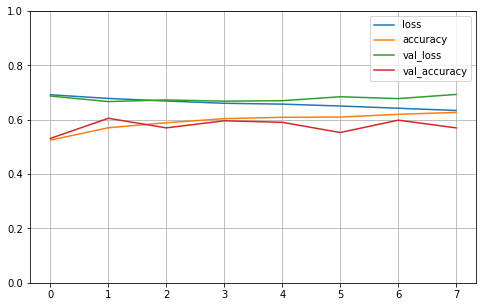


2023-03-26 20:20:11.891246

Testing # 2 4
2023-03-26 20:20:11.892341
2023-03-26 20:20:11.892646
PREDICT
2023-03-26 20:20:12.316742
Test 1:0 432:447 49.15%
Predict 1:0 586:293 66.67%
Test sizes (879, 4999) (879,)
Range of scores: 0.044850152 to 0.8766581
Score threshold 0.5
Confusion matrix
 [[181 266]
 [112 320]]
Normalized matrix
 [[0.20591581 0.30261661]
 [0.12741752 0.36405006]]


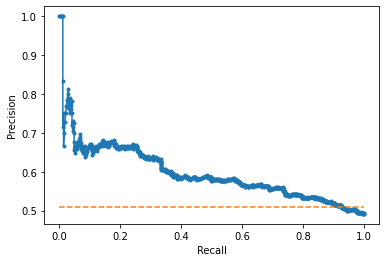

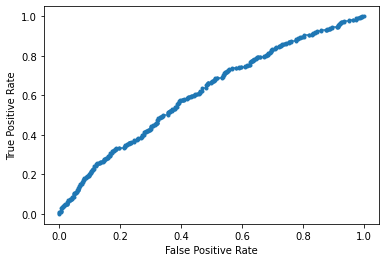

Accuracy: 57.00% Precision: 54.61% Recall: 74.07%
F1: 62.87% MCC: 0.1545
AUPRC: 59.70% AUROC: 61.35%
 accuracy [56.996587030716725]
 precision [54.60750853242321]
 recall [74.07407407407408]
 F1 [62.86836935166995]
 MCC [0.15447585236359793]
 AUPRC [59.695647718060215]
 AUROC [61.34621758223548]
2023-03-26 20:20:13.397118

Training # 2 5
2023-03-26 20:20:13.398823
2023-03-26 20:20:13.399172
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-26 20:20:15.424833


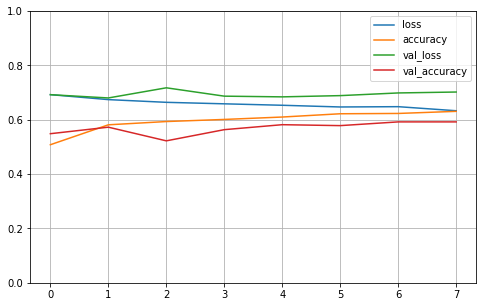


2023-03-26 20:20:37.213659

Testing # 2 5
2023-03-26 20:20:37.213995
2023-03-26 20:20:37.214036
PREDICT
2023-03-26 20:20:37.429622
Test 1:0 449:426 51.31%
Predict 1:0 630:245 72.00%
Test sizes (875, 4999) (875,)
Range of scores: 0.07317628 to 0.95475864
Score threshold 0.5
Confusion matrix
 [[157 269]
 [ 88 361]]
Normalized matrix
 [[0.17942857 0.30742857]
 [0.10057143 0.41257143]]


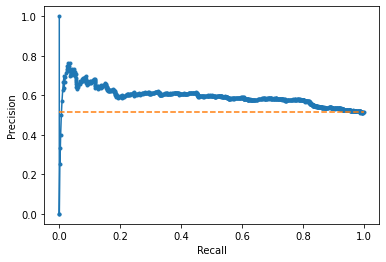

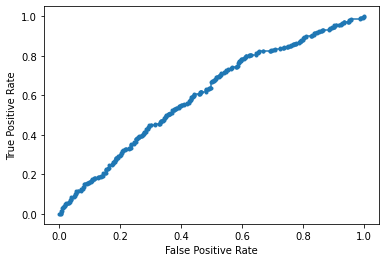

Accuracy: 59.20% Precision: 57.30% Recall: 80.40%
F1: 66.91% MCC: 0.1921
AUPRC: 59.37% AUROC: 60.45%
 accuracy [59.199999999999996]
 precision [57.3015873015873]
 recall [80.40089086859689]
 F1 [66.91380908248377]
 MCC [0.19208721066891898]
 AUPRC [59.36762901978372]
 AUROC [60.44888484582328]
2023-03-26 20:20:38.117741


In [23]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [24]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 58.73% std 1.25
 precision mean 58.10% std 2.10
 recall mean 73.53% std 9.29
 F1 mean 64.59% std 3.21
 MCC mean 0.18% std 0.02
 AUPRC mean 62.67% std 3.14
 AUROC mean 62.46% std 2.28
 accuracy [[58.50574712643678], [57.80542986425339], [57.126030624263834], [60.67415730337079], [57.99086757990868], [59.97745208568207], [59.907834101382484], [59.06976744186046], [56.996587030716725], [59.199999999999996]]
 precision [[61.25290023201856], [55.95854922279793], [58.15899581589959], [59.09849749582637], [56.0875512995896], [59.154929577464785], [60.4], [58.96980461811723], [54.60750853242321], [57.3015873015873]]
 recall [[57.64192139737992], [73.30316742081448], [62.89592760180995], [77.12418300653596], [89.71553610503283], [80.08474576271186], [66.8141592920354], [73.28918322295806], [74.07407407407408], [80.40089086859689]]
 F1 [[59.392575928008995], [63.46718903036239], [60.43478260869565], [66.91871455576559], [69.02356902356902], [68.04680468046804], [63.4453781512605],